In [1]:
# Import stuff
import pandas as pd
import matplotlib.pyplot as plt
import scipy.fft as fft
import scipy.signal as signal
import numpy as np
from library import empricial_auto_correlation
from fitting import polynomial_fit, eval_result, get_polynomial_funcs

In [2]:
# Load data and rename some keys
path = './Marseille_dataset_T_H_P.csv'

data_raw = pd.read_csv(path, header=12)
data = data_raw.copy()

# Clean up date format to a single column
data.insert(2, 'date', pd.to_datetime({'year': data_raw['YEAR'],
                                       'month': data_raw['MO'],
                                       'day': data_raw['DY']}
                                      ))
del data['YEAR']
del data['MO']
del data['DY']

# Rename column names to better names
data.rename(columns={'LAT': 'latitude', 'LON': 'longitude',
                            'T2M': 'temperature', 'PS': 'pressure',
                            'QV2M': 'humidity'}, inplace=True)

In [3]:
data['date'].describe()

count                    7610
unique                   7610
top       2007-09-10 00:00:00
freq                        1
first     2000-01-01 00:00:00
last      2020-10-31 00:00:00
Name: date, dtype: object

In [4]:
data.head()

,latitude,longitude,date,pressure,humidity,temperature
0,43.29531,5.37391,2000-01-01,101.42,4.79,6.85
1,43.29531,5.37391,2000-01-02,101.54,5.22,7.26
2,43.29531,5.37391,2000-01-03,101.86,5.66,9.29
3,43.29531,5.37391,2000-01-04,101.52,6.10,9.32
4,43.29531,5.37391,2000-01-05,101.07,6.31,9.57


In [5]:
# Set date to index and check for missing dates
data.set_index('date', inplace=True)
full_date_range = pd.date_range(
    min(data.index), max(data.index), freq='1D')
missing_dates = full_date_range[~full_date_range.isin(data.index)]

In [6]:
missing_dates

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

In [7]:
# No missing dates found

In [8]:
# Calculate FFT -> Amplitude and Phase
fft_temp = fft.rfft(data['temperature'].values)
fftfreq_daily = fft.rfftfreq(data['temperature'].size, 1)
fft_data = pd.DataFrame(data={'fft raw': fft_temp}, index=fftfreq_daily)
fft_data['real'] = np.real(fft_data['fft raw'])
fft_data['imag'] = np.imag(fft_data['fft raw'])
fft_data['psd'] = np.abs(fft_data['fft raw'])
fft_data['phase'] = np.arctan2(fft_data['real'], fft_data['imag'])

Text(0, 0.5, 'Phase')

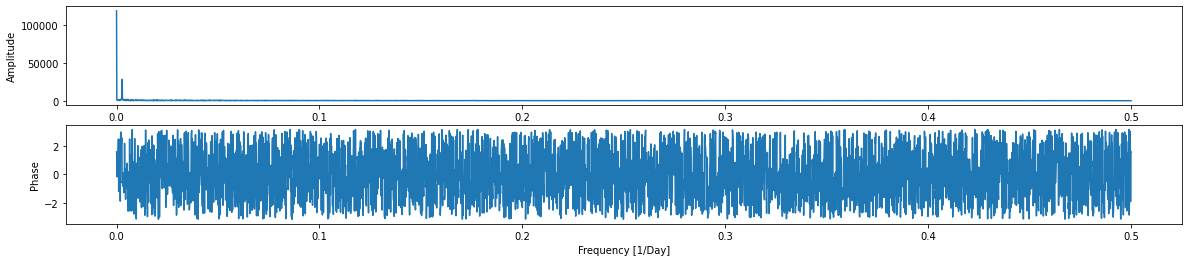

In [9]:
# Plot FFT results
fig, ax = plt.subplots(2, 1,figsize=[20,4])
ax[0].plot(fft_data.index, fft_data['psd'], color='tab:blue')
ax[0].set_xlabel('Frequency [1/Day]')
ax[0].set_ylabel('Amplitude')
ax[1].plot(fft_data.index, fft_data['phase'], color='tab:blue')
ax[1].set_xlabel('Frequency [1/Day]')
ax[1].set_ylabel('Phase')

In [10]:
# Keep only the N biggest peaks
N = 5
cut_off = fft_data['psd'].sort_values().values[-N]
fft_data['cleaned'] = fft_data['fft raw']
clean_mask = fft_data['psd'].values < cut_off
fft_data.loc[clean_mask, 'cleaned'] = 0
data['ifft'] = fft.irfft(fft_data['cleaned'].values)

In [11]:
# Keep the DC Peak only
fft_data['DC Peak'] = fft_data['fft raw']
fft_data['DC Peak'].iloc[1:] = 0
data['DC Peak'] = fft.irfft(fft_data['DC Peak'].values)

/home/dominik/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Text(0, 0.5, 'Inverse FFT with Noise Reduction [°C]')

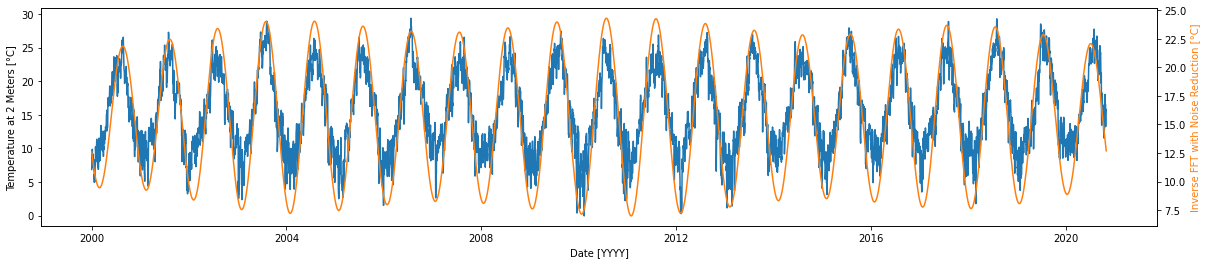

In [12]:
# Plot original data and the one "cleaned" one with only N peaks
fig, ax = plt.subplots(figsize=[20,4])
ax.plot(data.index, data['temperature'])
ax.set_xlabel('Date [YYYY]')
ax.set_ylabel('Temperature at 2 Meters [°C]')
ax2 = ax.twinx()
ax2.plot(data.index, data['ifft'], color='tab:orange')
ax2.set_ylabel('Inverse FFT with Noise Reduction [°C]', color='tab:orange')

In [13]:
# Calculate own autocorrelation
rho = []
for t in range(1, len(data['temperature'])):
    rho.append(empricial_auto_correlation(data['temperature'].values, t))

/home/dominik/Desktop/Time Series/Project 1/Marseille/library.py:16: RuntimeWarning: invalid value encountered in double_scalars
  np.sqrt(np.nansum(x_term**2) * np.nansum(y_term**2))


In [66]:
# Use rho to calculate improved standard deviation
std = np.sqrt((1 + 2 * abs(np.nansum(rho)) )/
              len(data['temperature'])) * np.std(data['temperature'])
np.std(data['temperature'])/np.sqrt(len(data['temperature']))

0.06791607924441512

In [15]:
print(
    'Avg. Temp.: ({0:.5f} +- {1:.5f})'.format(data['temperature'].mean(), std))

Avg. Temp.: (15.65821 +- 0.28964)


Text(0, 0.5, 'Empricial Autocorrelation')

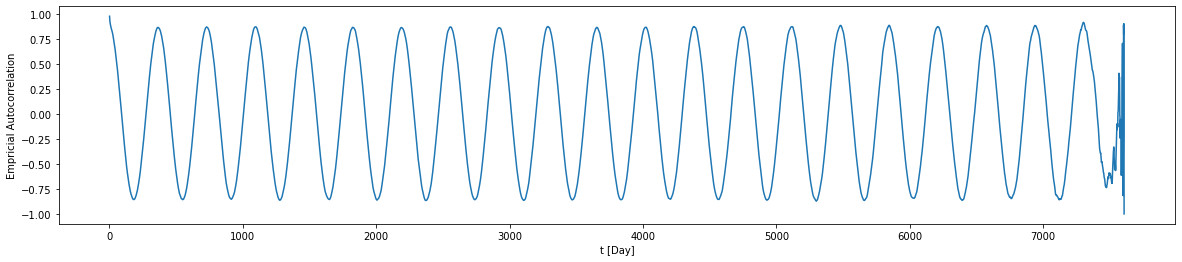

In [16]:
# Plot autocorrelation
fig, ax = plt.subplots(figsize=[20,4])
ax.plot(range(1,len(data['temperature'])), rho)
ax.set_xlabel('t [Day]')
ax.set_ylabel('Empricial Autocorrelation')

In [17]:
# Frequency of the five biggest peaks
important_freqs = fft_data['psd'][fft_data['cleaned']!=0]
important_freqs

0.000000    119158.990000
0.002365      2817.337237
0.002628      6168.107779
0.002760     28236.903399
0.002891      4167.105736
Name: psd, dtype: float64

In [18]:
# Wikipedia says there are 365.25 days in a year -> annual frequency
1/365.25

0.0027378507871321013

In [19]:
# Corresponds to the biggest non constant peak of 0.2760 1/day. I will try to find the uncertainty to our measurement the way I desribed.

In [20]:
# First lets look at the remaining signal without noise, mean temp or annual cycle
# yes I'm terrific at variable names....

In [21]:
fft_data['further cleaned'] = fft_data['cleaned']
fft_data.loc[important_freqs.index[[0,3]], 'further cleaned'] = 0
fft_data['psd'][fft_data['further cleaned']!=0]

0.002365    2817.337237
0.002628    6168.107779
0.002891    4167.105736
Name: psd, dtype: float64

In [22]:
data['ifft cleaned'] = fft.irfft(fft_data['further cleaned'].values)

Text(0, 0.5, 'Inverse FFT with Noise Reduction [°C]')

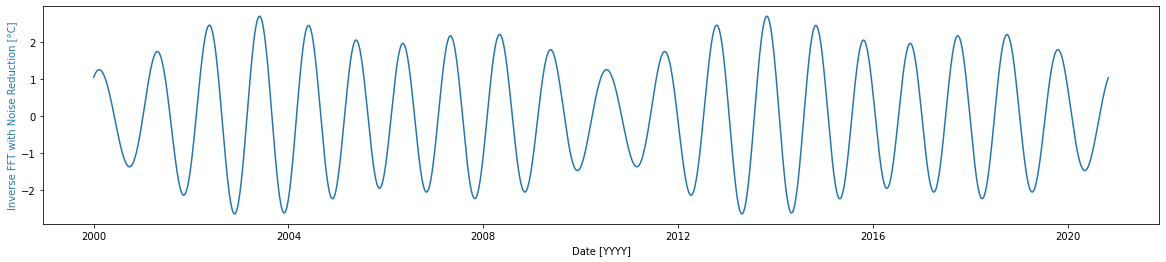

In [23]:
fig, ax = plt.subplots(figsize=[20,4])
ax.set_xlabel('Date [YYYY]')
ax.plot(data.index, data['ifft cleaned'], color='tab:blue')
ax.set_ylabel('Inverse FFT with Noise Reduction [°C]', color='tab:blue')

In [24]:
# Ok this still looks like an annual cycle which is not very surprising looking at the frequencies. They are all
# close to the annual frequency but not exact. This also explains a different kind of phenomena I noticed: beat (Schwebung)
# in German (https://en.wikipedia.org/wiki/Beat_(acoustics))
# Not sure what do to with this information yet

In [25]:
# Find the peaks to interpolate the annual cycle
peaks = signal.find_peaks(data['ifft'])

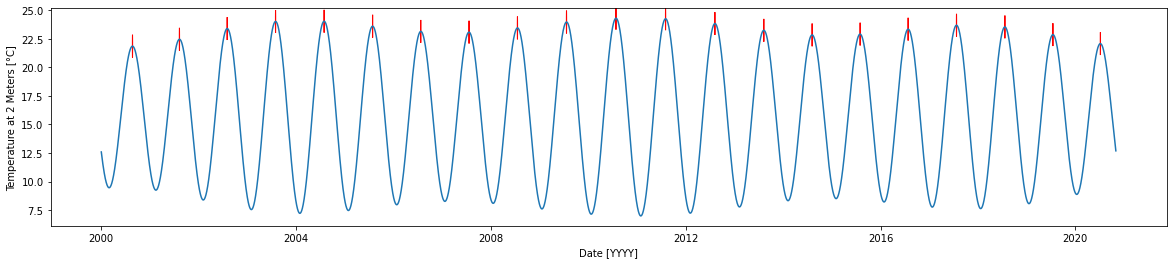

In [26]:
fig, ax = plt.subplots(figsize=[20,4])
ax.plot(data.index, data['ifft'])
ax.set_xlabel('Date [YYYY]')
ax.set_ylabel('Temperature at 2 Meters [°C]')
for peak in peaks[0]:
    circle = plt.Circle((data.index[peak],data['ifft'].iloc[peak]), 1, color='r')
    ax.add_artist(circle)

In [27]:
peak_index = list(range(len(peaks[0])))
days = data.index[peaks[0]].to_series() - data.index[peaks[0]].to_series()[0]
peak_frame = pd.DataFrame(data={'days': days.values}, index=peak_index)
days = peak_frame['days'].dt.days.values
days_diff = abs(days[:-1]-days[1:])

Text(0, 0.5, 'Days between Peaks')

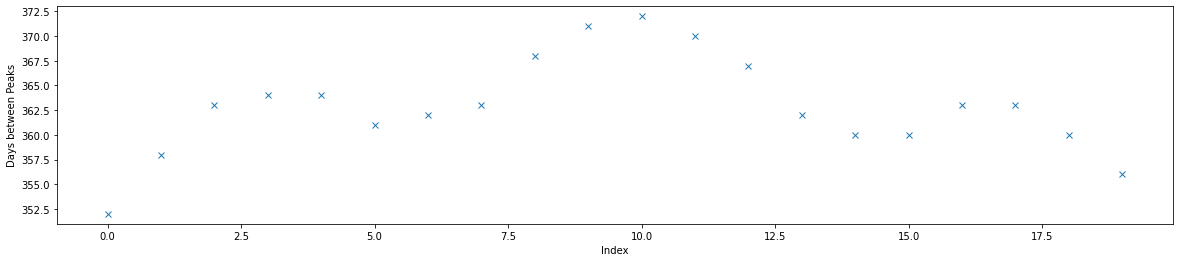

In [28]:
fig, ax = plt.subplots(figsize=[20,4])
ax.plot(range(len(days_diff)), days_diff, linestyle='None', marker='x')
ax.set_xlabel('Index')
ax.set_ylabel('Days between Peaks')

In [29]:
print(
    'Avg. Year.: ({0:.5f} +- {1:.5f})'.format(np.mean(days_diff), np.std(days_diff)))

Avg. Year.: (362.95000 +- 4.82157)


In [30]:
# Again do a autocorrelation correction
rho = []
for t in range(1, len(days_diff)):
    rho.append(empricial_auto_correlation(days_diff, t))

std = np.sqrt((1 + 2 * abs(np.nansum(rho)) )/
              len(days_diff)) * np.std(days_diff)

print(
    'Avg. Year.: ({0:.5f} +- {1:.5f})'.format(np.mean(days_diff), std))

Avg. Year.: (362.95000 +- 3.95429)


/home/dominik/Desktop/Time Series/Project 1/Marseille/library.py:16: RuntimeWarning: invalid value encountered in double_scalars
  np.sqrt(np.nansum(x_term**2) * np.nansum(y_term**2))


In [31]:
parameter, *_ =polynomial_fit(range(len(days_diff)), days_diff, sigma=1, order=1)

In [32]:
funcs = get_polynomial_funcs(1)
x_mod = np.linspace(min(range(len(days_diff))) / 1.1, max(range(len(days_diff))) * 1.1, 50)
y_mod = eval_result(x_mod, parameter, funcs)

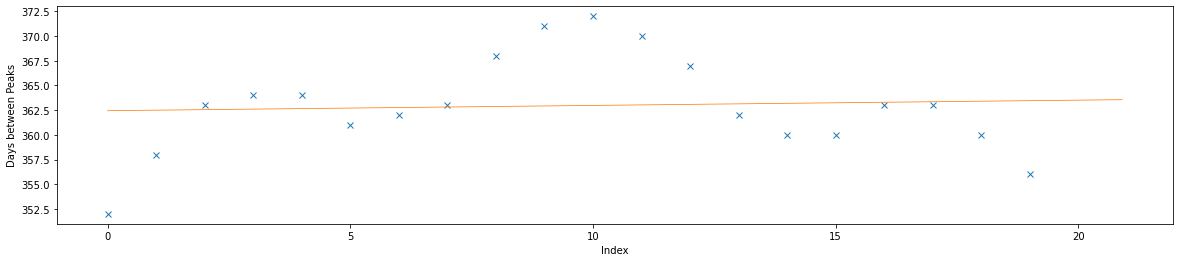

In [33]:
fig, ax = plt.subplots(figsize=[20,4])
ax.plot(range(len(days_diff)), days_diff, linestyle='None', marker='x')
ax.set_xlabel('Index')
ax.set_ylabel('Days between Peaks')
ax.plot(x_mod, y_mod, label=fr'Linear Fit', linewidth=0.75, color='tab:orange')

In [41]:
parameter, _,C, *_ =polynomial_fit(range(len(days)), days, sigma=1, order=1)

In [35]:
funcs = get_polynomial_funcs(1)
x_mod = np.linspace(min(range(len(days_diff))) / 1.1, max(range(len(days_diff))) * 1.1, 50)
y_mod = eval_result(x_mod, parameter, funcs)

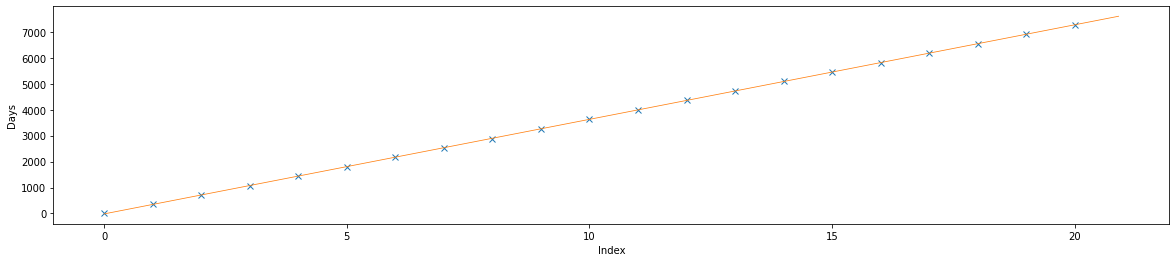

In [36]:
fig, ax = plt.subplots(figsize=[20,4])
ax.plot(range(len(days)), days, linestyle='None', marker='x')
ax.set_xlabel('Index')
ax.set_ylabel('Days')
ax.plot(x_mod, y_mod, label=fr'Linear Fit', linewidth=0.75, color='tab:orange')

In [37]:
parameter

array([-16.34632035, 364.41558442])

In [42]:
variance = np.diagonal(C)

In [43]:
variance

array([0.17748918, 0.0012987 ])

In [46]:
# This way the result is much closer to the expected 365.25 days but there isn't really any uncertainty since there are only 3 frequencies.

In [48]:
# Investigate the noise
N = 5
cut_off = fft_data['psd'].sort_values().values[-N]
fft_data['noise'] = fft_data['fft raw']
clean_mask = fft_data['psd'].values > cut_off
fft_data.loc[clean_mask, 'noise'] = 0
data['noise'] = fft.irfft(fft_data['noise'].values)

Text(0, 0.5, 'Noise')

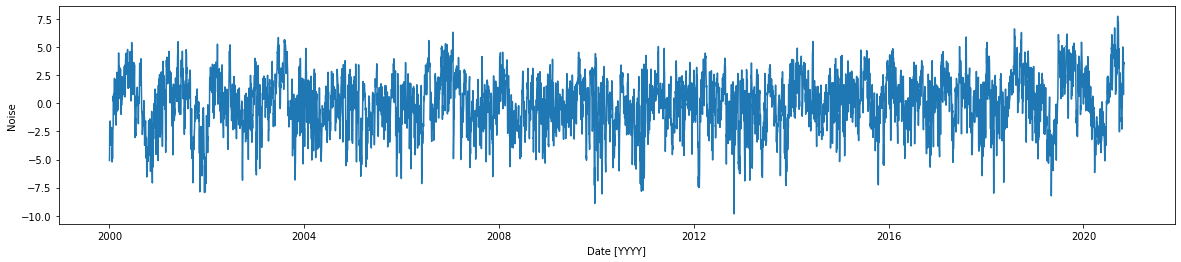

In [50]:
fig, ax = plt.subplots(figsize=[20,4])
ax.plot(data.index, data['noise'])
ax.set_xlabel('Date [YYYY]')
ax.set_ylabel('Noise')

In [51]:
data['noise'].autocorr

<bound method Series.autocorr of date
2000-01-01   -5.084887
2000-01-02   -4.573026
2000-01-03   -2.442356
2000-01-04   -2.312909
2000-01-05   -1.964715
                ...   
2020-10-27    0.779056
2020-10-28    2.826392
2020-10-29    3.132698
2020-10-30    3.657942
2020-10-31    3.522091
Name: noise, Length: 7610, dtype: float64>

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

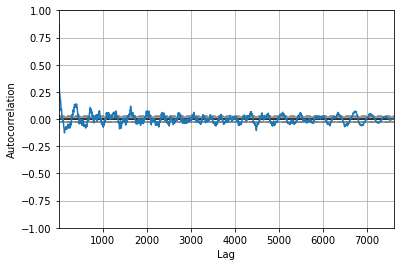

In [52]:
pd.plotting.autocorrelation_plot(data['noise'])

In [53]:
# Very little autocorrelation in the noise and no visible pattern in the noise

In [54]:
fft_data['psd noise'] = np.abs(fft_data['noise'])

/home/dominik/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'Amplitude')

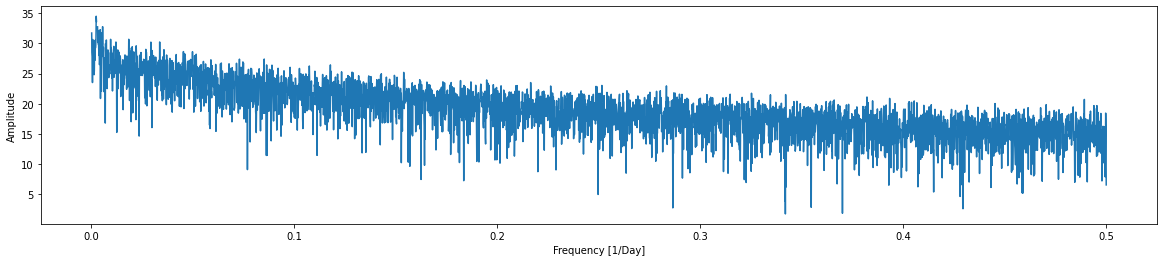

In [57]:
# Plot Noise Spectrum
fig, ax = plt.subplots(figsize=[20,4])
ax.plot(fft_data.index, 10*np.log10(fft_data['psd noise']), color='tab:blue')
ax.set_xlabel('Frequency [1/Day]')
ax.set_ylabel('Amplitude')

In [58]:
# Ok so nothing special to see in the noise

In [62]:
# Moving average
data['rolling avg 10'] = data['temperature'].rolling(window=10).mean()

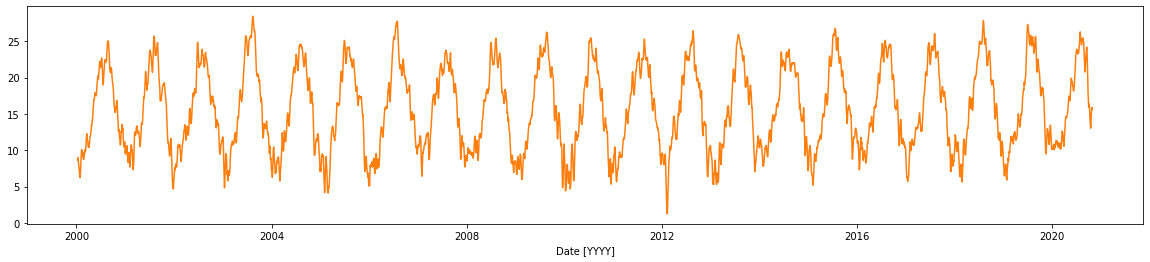

In [65]:
fig, ax = plt.subplots(figsize=[20,4])
ax.set_xlabel('Date [YYYY]')
ax.plot(data.index, data['rolling avg 10'], color='tab:orange')